# Animal Shelter (XGBoost)


In [240]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [241]:
df = pd.read_csv("train.csv")

In [242]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [243]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


# 1. Data  Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [244]:
def splitSex(df):
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)
    df[["SexuponOutcome", "Sex", "Neutered"]].head()
    
splitSex(df)

In [245]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

Explore the sex and intactness fields visually with respect to outcome. It appears that being neutered is a fair predictor for adoption.

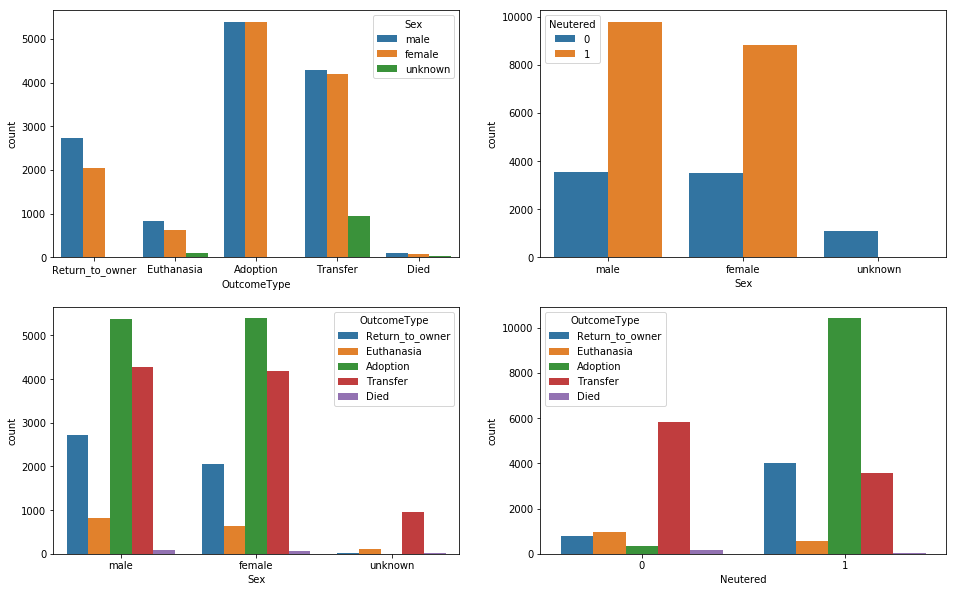

In [246]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up the breed field. Here we determine if an animal is a purebreed or a mix and create a new field encoding this information.

In [247]:
def cleanupBreed(df):
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

Plot normalized ratios of outcomes by breed purity. It looks like purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

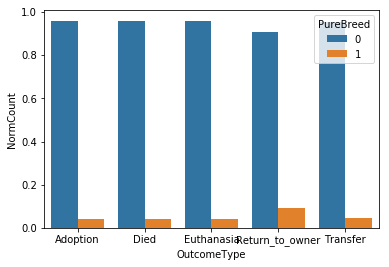

In [248]:
# Normalize counts over imbalanced categories.
# if norm_over_x=True, x counts are normalized. If False, sub_x counts are normalized.
def normalizeCounts(df, x, sub_x, norm_over_x=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if norm_over_x:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not norm_over_x:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

# Plot bar chart of outcomes split by pureBreed, normalized over Outcome.
sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed", norm_over_x=True), x="OutcomeType", hue="PureBreed", y="NormCount")

The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [249]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

breedsVec = TfidfVectorizer()
def preprocessBreed(df):
    #vec = CountVectorizer()
    
    breedsVec.fit(df["Breed"])#.str.replace("Mix", "").str.replace("/", " ").str.lower())
    
    
    return breedsVec
    
def processBreed(df, pca=False):
    breedsTDM = breedsVec.transform(df["Breed"])#.str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.toarray().shape
    
    if pca:
        pca = PCA()  
        pca.fit(breedsTDM.toarray())

        cumul_variance = [sum(pca.explained_variance_ratio_[:i]) for i in range(len(pca.explained_variance_ratio_))]
        print sum(pca.explained_variance_ratio_[:3])
       # print pca.explained_variance_ratio_
        #print cumul_variance

        numDims = len(cumul_variance)
        for i in range(len(cumul_variance)):
            if cumul_variance[i]>=0.9:
                numDims = i
                break

        print "NumDims=", numDims

        reduced_dims = pca.transform(breedsTDM.toarray())
        reduced_dims = reduced_dims[:,:numDims]

        print reduced_dims.shape
        breedsdf = pd.DataFrame(reduced_dims)#breedsTDM.toarray())
        breedCols = ["Breed_"+str(i) for i in range(0, reduced_dims.shape[1]) ]
        breedsdf.columns = breedCols
        #print breedsdf.head()

        df = df.join(breedsdf)
    else:
        breedsdf = pd.DataFrame(breedsTDM.toarray())
        breedCols = ["Breed_"+breedsVec.get_feature_names()[i] for i in range(0, breedsTDM.shape[1]) ]
        breedsdf.columns = breedCols
        #print breedsdf.head()

        df = df.join(breedsdf)

    #print df.head()
    return df


preprocessBreed(df)
df = processBreed(df, False)
df.head()


(26729, 262)
AnimalID
Name
DateTime
OutcomeType
OutcomeSubtype
AnimalType
SexuponOutcome
AgeuponOutcome
Breed
Color
Sex
Neutered
HasName
PureBreed
Breed_abyssinian
Breed_affenpinscher
Breed_afghan
Breed_airedale
Breed_akita
Breed_alaskan
Breed_american
Breed_anatol
Breed_angora
Breed_apso
Breed_argentino
Breed_australian
Breed_balinese
Breed_basenji
Breed_basset
Breed_bay
Breed_beagle
Breed_bearded
Breed_beauceron
Breed_bedlington
Breed_belgian
Breed_bengal
Breed_bernard
Breed_bernese
Breed_bichon
Breed_black
Breed_bloodhound
Breed_blue
Breed_bluetick
Breed_bobtail
Breed_boerboel
Breed_bombay
Breed_bordeaux
Breed_border
Breed_borzoi
Breed_boston
Breed_boxer
Breed_boykin
Breed_brindle
Breed_british
Breed_brittany
Breed_brown
Breed_bruss
Breed_bull
Breed_bulldog
Breed_bullmastiff
Breed_burmese
Breed_cairn
Breed_canaan
Breed_canario
Breed_cane
Breed_cardigan
Breed_carolina
Breed_cat
Breed_catahoula
Breed_cattle
Breed_cavalier
Breed_chesa
Breed_chihuahua
Breed_chin
Breed_chinese
Breed_chow

We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [250]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
processAge(df)


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

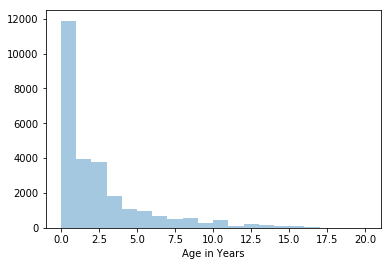

In [251]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that juveniles are more likely to be adopted than any other age bracket. Babies are less likely to be adopted as shelters usually don't allow them to until they are weaned and are also the most likely to die, or be transferred. Interestingly senior dogs are more likely to be returned to their owner. These facts should have explanatory value in our model.

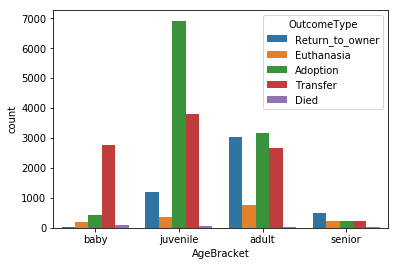

In [252]:
# Plot unnormalized...
sns.countplot(data=df, x="AgeBracket", hue="OutcomeType", order=["baby", "juvenile", "adult", "senior"])


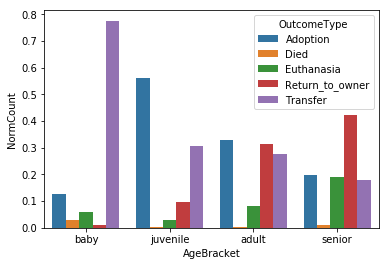

In [253]:

#...and normalized data
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType", norm_over_x=True), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "juvenile", "adult", "senior"])

Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 17:00 (unsurprising as it is the time most people finish their dayjob)

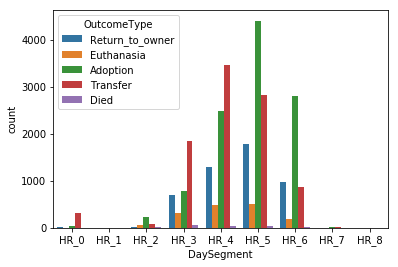

In [254]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
    df["OutcomeHour"] = df["DateTime"].dt.hour
    
processDate(df)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

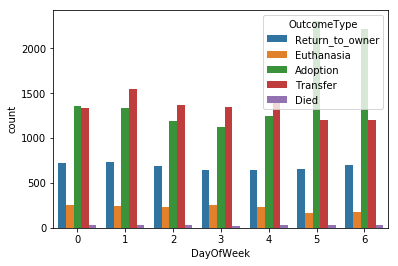

In [255]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

Create an "IsWeekend" feature to hopefully help the classifier along.

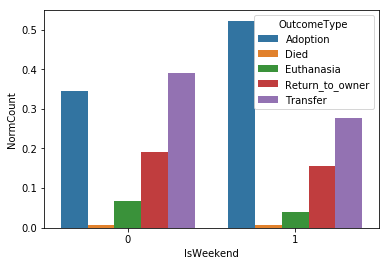

In [256]:
def processWeekend(df):
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)

processWeekend(df)
sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", norm_over_x=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Some more visual exploration relating to the outcome datetime field. Plot outcomes by month, day and hour. One can see interesting cyclicity in this data. In particular the peaks in adoption around Christmas and around July/August (summer holidays!)

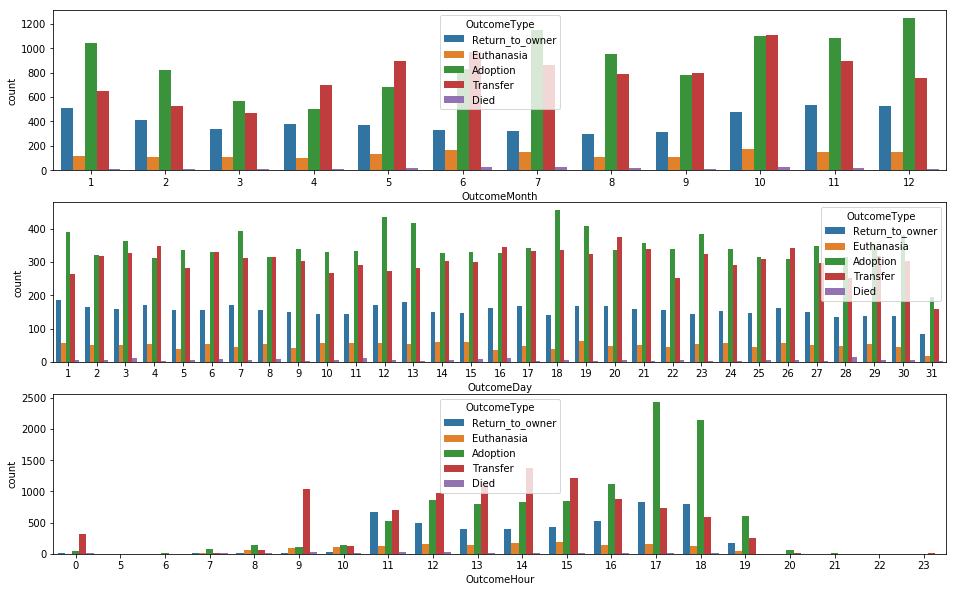

In [257]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
sns.countplot(data=df, x="OutcomeMonth", hue="OutcomeType", ax=ax1)
sns.countplot(data=df, x="OutcomeDay", hue="OutcomeType", ax=ax2)
sns.countplot(data=df, x="OutcomeHour", hue="OutcomeType", ax=ax3)
plt.show()

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

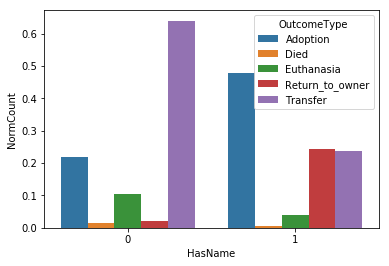

In [258]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

#sns.countplot(data=df, x="HasName", hue="OutcomeType")
sns.barplot(data=normalizeCounts(df, "HasName", "OutcomeType", norm_over_x=True), x="HasName", hue="OutcomeType", y="NormCount")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [259]:
df["Color"].unique().size

366

In [260]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


processColor(df)

print df["SimpleColor"].unique().size
df[["Color", "SimpleColor"]].head()


29


,Color,SimpleColor
0,Brown/White,brown
1,Cream Tabby,cream
2,Blue/White,blue
3,Blue Cream,blue
4,Tan,tan


['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


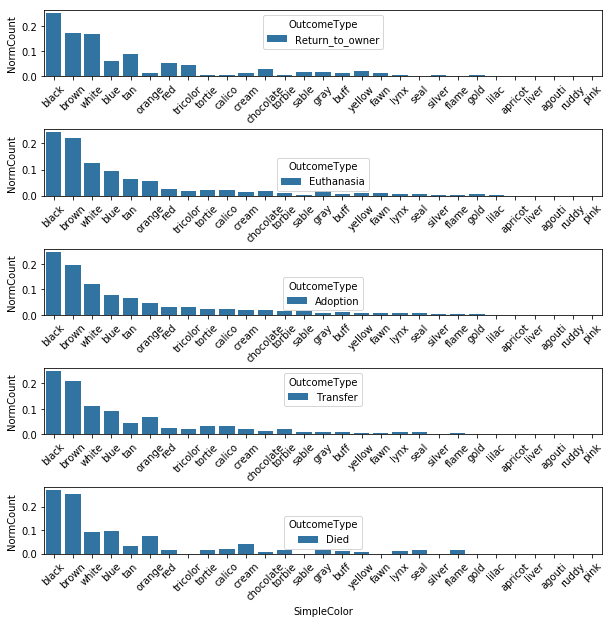

In [261]:
outcomes = df["OutcomeType"].unique()
print outcomes
f, ax1 = plt.subplots(outcomes.size, 1, figsize=(10, 10))

df["SimpleColor"].value_counts().index
for i in range(0,len(outcomes)):
    outcome = outcomes[i]
    ax1[i].tick_params(axis="x", rotation=45)
    sns.barplot(data=normalizeCounts(df.loc[df["OutcomeType"]==outcome,:], x="SimpleColor", sub_x="OutcomeType", norm_over_x=False), x="SimpleColor", hue="OutcomeType", y="NormCount", order=df["SimpleColor"].value_counts().index, ax=ax1[i])
    
f.subplots_adjust(hspace=0.8)

How balanced or unbalanced are our classes?

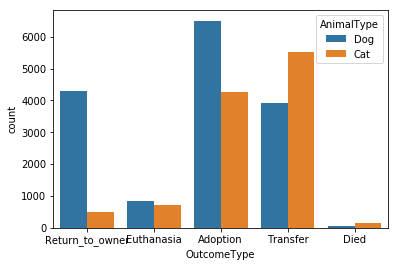

In [262]:
sns.countplot(data=df, x="OutcomeType", hue="AnimalType")

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [263]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [264]:
df.head()


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_wolfhound,Breed_yorkshire,AgeDays,AgeBracket,DaySegment,OutcomeDay,OutcomeMonth,OutcomeHour,IsWeekend,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.0,365.0,juvenile,HR_6,12,2,18,0,brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.0,365.0,juvenile,HR_4,13,10,12,1,cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.0,730.0,adult,HR_4,31,1,12,1,blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.0,21.0,baby,HR_6,11,7,19,0,blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.0,730.0,adult,HR_4,15,11,12,0,tan


Select only the fields we need for learning.

In [265]:
prepared_df = df.copy()
prepared_df = prepared_df.drop(["AnimalID", "Name", "DateTime", "OutcomeSubtype", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_df.head()

       OutcomeType AnimalType     Sex  Neutered  HasName  PureBreed  \
0  Return_to_owner        Dog    male         1        1          0   
1       Euthanasia        Cat  female         1        1          0   
2         Adoption        Dog    male         1        1          0   
3         Transfer        Cat    male         0        0          0   
4         Transfer        Dog    male         1        0          0   

   Breed_abyssinian  Breed_affenpinscher  Breed_afghan  Breed_airedale  \
0               0.0                  0.0           0.0             0.0   
1               0.0                  0.0           0.0             0.0   
2               0.0                  0.0           0.0             0.0   
3               0.0                  0.0           0.0             0.0   
4               0.0                  0.0           0.0             0.0   

      ...       Breed_wolfhound  Breed_yorkshire  AgeDays  AgeBracket  \
0     ...                   0.0              0.0    365

Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [266]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None),
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder()),
], df_out=True)




In [267]:
# Transform the target field
classes_array = labelMapper.fit_transform(prepared_df)

# Transform the independent features
prepared_fitted_df = mapper.fit_transform(prepared_df)

# Drop redundant columns to avoid the Dummy Variable Trap
# This is not needed for Tree-based classifiers such as XGBoost, however
# it is good practice anyway
prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "SimpleColor", "OutcomeType" ], axis=1)

# Convert the features dataframe to an array so as to be able to pass the data
# to the learning functions.
features_array = prepared_fitted_df.values 

#print prepared_fitted_df.columns
#print classes_array.head()
#prepared_fitted_df.head()


As can be seen here the data is severely imbalanced. 

In [268]:
classnames = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

for c in range(0,5):
    print classnames[c], "=", len(classes_array.loc[classes_array["OutcomeType"]==c])

Adoption = 10769
Died = 197
Euthanasia = 1555
Return_to_owner = 4786
Transfer = 9422


Supersample the data using the SMOTE algorithm so as to mitigate the problem of class imbalance.

NB. Here we used the library downloadable from http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html

In [269]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

# Split the dataset into Train/Test
X_train, X_test, y_train, y_test = train_test_split(features_array, classes_array.values, test_size=0.2, random_state=42, stratify=classes_array)

# Supersample the minitority class slightly.
#sm = SMOTE(random_state=42, n_jobs=4, ratio={1:1000})
#X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# Restore the y_train array shape as SMOTE reshapes it.
#y_train = np.transpose(y_train[np.newaxis])

print features_array.shape
print classes_array.shape
print X_train.shape
print y_train.shape


(26729, 284)
(26729, 1)
(21383, 284)
(21383, 1)


Define a function to plot Receiver Operating Characteristic curves for the outcome class labels.

In [270]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plotROCCurves(classes, classlabels, y_test_bin, y_test_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    print int(np.ceil(float(len(classes))/2)), 2
    f, plts = plt.subplots(int(np.ceil(float(len(classes))/2)), 2, figsize=(10, 10))

    plts = plts.ravel()
    lw = 2

    #classlabels=labelMapper.features[0][1].inverse_transform(classes)

    for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
        #plt.subplot(3,2,cls+1)
        if (cls < len(classes)):
            plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
            plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plts[cls].set_xlim([0.0, 1.0])
            plts[cls].set_ylim([0.0, 1.05])
            plts[cls].set_xlabel('False Positive Rate')
            plts[cls].set_ylabel('True Positive Rate')
            plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
            plt.legend(loc="lower right")
        else:
            plts[cls].axis("off")

    f.subplots_adjust(hspace=0.4)
    plt.show()
    


The XGBoost classifier, similar to RandomForest, has a feature importance/selection feature which we use here to perform feature reduction on our dataset.

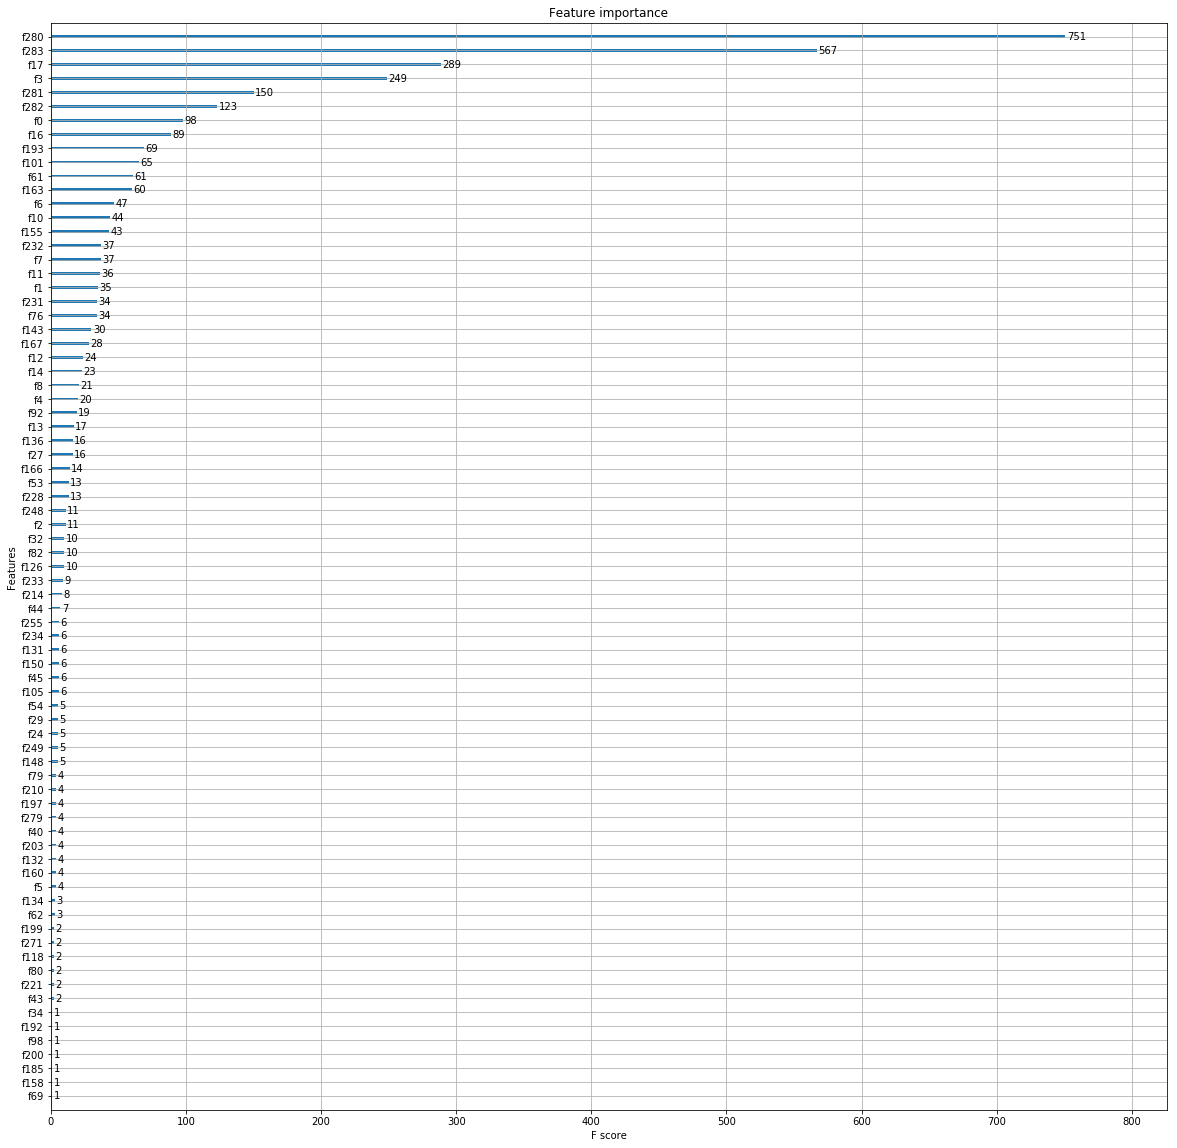

Threshold= 1e-05 : Re-fitting with  77  features instead of  284
f1 score= 0.657056792908
log loss= 0.794645595989
Threshold= 2.78255940221e-05 : Re-fitting with  77  features instead of  284
f1 score= 0.657056792908
log loss= 0.794645595989
Threshold= 7.74263682681e-05 : Re-fitting with  77  features instead of  284
f1 score= 0.657056792908
log loss= 0.794645595989
Threshold= 0.000215443469003 : Re-fitting with  77  features instead of  284
f1 score= 0.657056792908
log loss= 0.794645595989
Threshold= 0.000599484250319 : Re-fitting with  64  features instead of  284
f1 score= 0.657626662931
log loss= 0.794566296343
Threshold= 0.0016681005372 : Re-fitting with  48  features instead of  284
f1 score= 0.658387618055
log loss= 0.79393716652
Threshold= 0.00464158883361 : Re-fitting with  31  features instead of  284
f1 score= 0.659084261955
log loss= 0.793680307241
Threshold= 0.0129154966501 : Re-fitting with  14  features instead of  284
f1 score= 0.654014922928
log loss= 0.796036025502
Th

In [271]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Define an instance of XGBoost and fir the training set to it
fselGB = xgb.XGBClassifier(n_jobs=4)
fselGB.fit(X_train, y_train[:,0])

# Plot feature importances visually
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(fselGB, ax=ax)
plt.show()

# In order to determine which features tp select for our model, we iterate on a threshold value.
# Any feature with an importance value smaller than the threshold is removed and the model performance
# is determined in terms of f1 score and log loss. 
# In this way we determine the threshold value at which the performance is maximised and hence which features
# to include in our model.
thresholds_for_test = np.geomspace(0.00001, 0.1, 10, endpoint=True)
f1scores=[]
loglosses=[]
paramsleft=[]
for thresh in thresholds_for_test:
    support = fselGB.feature_importances_>thresh
    print "Threshold=", thresh, ": Re-fitting with ", np.sum(support), " features instead of ", len(support)
    
    GB2 = xgb.XGBClassifier(n_jobs=4)

    GB2.fit(X_train[:,support], y_train[:,0])

    preds = GB2.predict(X_test[:,support])
    proba = GB2.predict_proba(X_test[:,support])

    f1score = f1_score(y_test, preds, average="weighted")
    logloss = log_loss(y_test, proba, labels=GB2.classes_)
    print "f1 score=", f1score
    print "log loss=", logloss

    f1scores.append(f1score)
    loglosses.append(logloss)
    paramsleft.append(np.sum(support))


In [272]:
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults

[array([  1.00000000e-05,   2.78255940e-05,   7.74263683e-05,
         2.15443469e-04,   5.99484250e-04,   1.66810054e-03,
         4.64158883e-03,   1.29154967e-02,   3.59381366e-02,
         1.00000000e-01]), [77, 77, 77, 77, 64, 48, 31, 14, 6, 2], [0.65705679290841534, 0.65705679290841534, 0.65705679290841534, 0.65705679290841534, 0.65762666293054894, 0.65838761805543089, 0.65908426195462977, 0.65401492292823138, 0.63249648157199134, 0.56170265470434588], [0.79464559598933537, 0.79464559598933537, 0.79464559598933537, 0.79464559598933537, 0.79456629634274223, 0.79393716652003443, 0.7936803072414319, 0.79603602550226993, 0.82901641281633132, 0.97587614105662468]]


Plot the resultant f1 scores and log loses vs. threshold in order to get a visual understanding of the effect of feature reduction on the model performance.
Use the calculated scores to determine the optimal threshold.

Will use threshold  0.00464158883361
[ True  True False  True  True False  True  True  True False  True  True
  True  True  True False  True  True False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False  True False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False  True
 False False False False False False False False False False False  True
 False False F

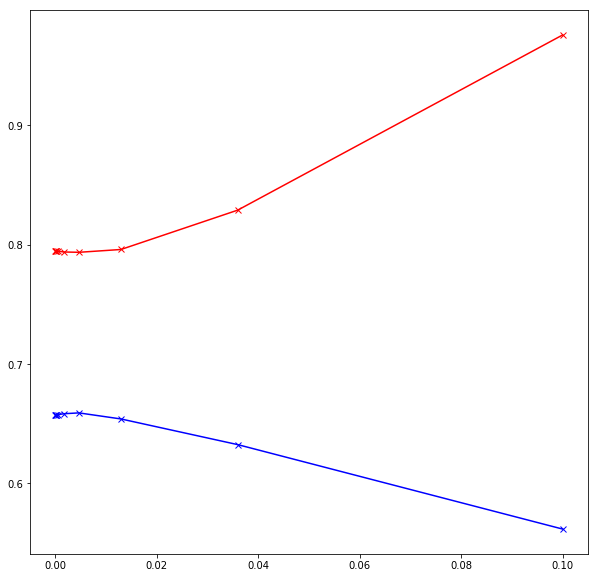

In [273]:
f, ax = plt.subplots(1, figsize=(10,10))
plt.plot(thresholds_for_test, f1scores, "bx-", thresholds_for_test, loglosses, "rx-",)

f1_thresh = np.argsort(f1scores)[-1] # index of best f1 score
ll_thresh = np.argsort(loglosses)[0] # index of best log loss

# Average the two
final_threshold = np.average((thresholds_for_test[f1_thresh], thresholds_for_test[ll_thresh]))

# final_support is now a boolean array masking out the most important features.
final_support = fselGB.feature_importances_>=final_threshold

print "Will use threshold ", final_threshold
print final_support

# Save the contents of X_test before feature reduction.
#X_test_pre_red = X_test

# Reduce the features on the training and test sets
X_train = X_train[:,final_support]
X_test = X_test[:, final_support]



Print the selected column names in order of importance. 

We can see that the features identified as expanatory in the Data Exploration section also appear here. This is expected and is a good indication that we are selecting the correct fields.

It is also interesting to see which breeds/breed features are he most important.

In [274]:
sortedIndexes = np.argsort(fselGB.feature_importances_)[::-1]
colnames= prepared_fitted_df.columns.values
#colnames = np.append(colnames, "SimpleOutcome")

print colnames[sortedIndexes][final_support[sortedIndexes]]

['AgeDays' 'OutcomeHour' 'HasName' 'Neutered' 'OutcomeDay' 'OutcomeMonth'
 'AnimalType' 'IsWeekend' u'Breed_pit' u'Breed_domestic' u'Breed_bull'
 u'Breed_mastiff' 'AgeBracket_baby' 'DaySegment_HR_2' u'Breed_longhair'
 u'Breed_shorthair' 'AgeBracket_juvenile' 'DaySegment_HR_3' 'Sex_female'
 u'Breed_chihuahua' u'Breed_shih' u'Breed_jack' u'Breed_mix'
 'DaySegment_HR_4' 'DaySegment_HR_6' 'DaySegment_HR_0' 'PureBreed'
 u'Breed_dachshund' 'DaySegment_HR_5' u'Breed_husky' u'Breed_apso']


In [184]:
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# We use the genetic algorithm cross validation search library at https://github.com/rsteca/sklearn-deap 
# in order to optimize the XGBoost Hyperparameters.
from evolutionary_search import EvolutionaryAlgorithmSearchCV

# Ideally we use approx. 10 folds
k_fold = 3
  
# Use Stratified KFold so as to mitigate the effects of the imbalanced dataset.
# Stratified k-fold makes sure that the cross validation folds are always selected with the same 
# ratio of outcome classes
cv = StratifiedKFold(y_train[:,0],n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
# Define the hyperparamer ranges inside which we want to optimize our model
param_grid = {'max_depth': [500],
              'learning_rate': np.arange(0.1,0.5, 0.1),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': np.geomspace(3, 15, 10, endpoint=True),
              'colsample_bytree': np.arange(0.25, 0.55, 0.02),
              'colsample_bylevel': np.arange(0.45, 0.85, 0.2),
              'subsample': np.arange(0.80, 1, 0.01),
              'n_estimators': np.arange(50, 300, 20)}
  
#param_grid = {'max_depth': [500],
#              'learning_rate': np.arange(0.15, 0.25, 0.01),
#              'objective':['multi:softprob'],
#              'n_jobs': [3],
#              'missing': [np.nan],
#              'reg_alpha': np.geomspace(3, 10, 10, endpoint=True),
#              'colsample_bytree': np.arange(0.45, 0.55, 0.01),
#              'colsample_bylevel': np.arange(0.75, 0.85, 0.01),
#              'subsample': np.arange(0.85, 0.95, 0.01),
#              'n_estimators': np.arange(50, 100, 10)}

#param_grid = {'max_depth': [500],
#              'learning_rate': np.arange(0.25, 0.35, 0.02),
#              'objective':['multi:softprob'],
#              'n_jobs': [2],
#              'missing': [np.nan],
#              'reg_alpha': np.geomspace(9, 11, 10, endpoint=True),
#              'colsample_bytree': np.arange(0.25, 0.35, 0.02),
#              'colsample_bylevel': np.arange(0.45, 0.55, 0.02),
#              'subsample': np.arange(0.85, 1, 0.02),
#              'n_estimators': np.arange(90, 110, 10)}

search_GB = EvolutionaryAlgorithmSearchCV(estimator=GB,
                                   params=param_grid,
                                   scoring="neg_log_loss",
                                   cv=cv,
                                   verbose=10,
                                   population_size=50,
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=5,
                                   generations_number=10,
                                   n_jobs=3)

search_GB.fit(X_train,y_train[:,0])
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_



Types [1, 2, 2, 1, 2, 2, 1, 2, 2, 1] and maxint [12, 19, 9, 0, 15, 0, 0, 3, 1, 0] detected
--- Evolve in 332800 possible combinations ---
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=270, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.83, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=150, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.787794239907, total=  18.0s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsampl

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=230, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.801994082616, total=  29.4s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.33, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=150, subsample=0.99, objective=multi:softprob, max_depth=500, score=-0.777692668651, total=  13.4s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=150, subsample=0.99, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=150, subsample=0.99, objec

[CV] reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=50, subsample=0.98, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.783039610769, total=  13.5s
[CV] reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.84, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=50, subsample=0.98, objective=multi:softprob, max_depth=500, score=-0.799175667375, total=   5.0s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=190, subsample=0.9

[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.798911197399, total=  10.9s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=170, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.815335481715, total=  30.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=250, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=170, subsample=0

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=110, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.89, objective=multi:softprob, max_depth=500, score=-0.776905054046, total=  27.0s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.39, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.89, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.31, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=190, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.781844301417, total=  15.0s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.31, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=190, subsample=0.84, objective=mul

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.794909126754, total=   5.0s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.83, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=230, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.782658755019, total=  18.1s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=230, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.3, colsample_bylevel=0.45, n_estimators=50, subsample=0.83, objective=multi:softprob, max

[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=250, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=230, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.798187743919, total=  15.9s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.25, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=230, subsample=0.83, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=170, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.810283282717, total=  21.3s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=170, subsample=0

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.785376133912, total=  18.1s
[CV] reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.89, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=12.5437654643, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=250, subsample=0.86, objective=multi:softprob, max_depth=500, score=-0.791117691434, total=  24.0s
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.55, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=230, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.839896188985, total=  32.5s
[CV] reg_alpha=3.5874395235, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_e

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.783806225419, total=  20.8s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.784609292068, total=  14.2s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=250, subsample=0

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.777677074384, total=  23.5s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.780563046695, total=  26.0s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=

[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=270, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.779333716182, total=  28.4s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=270, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=70, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.792196226592, total=   8.7s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.9

[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.78340642257, total=  22.5s
[CV] reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=15.0, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.790187118544, total=  22.2s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.41, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softpro

[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=130, subsample=0.89, objective=multi:softprob, max_depth=500, score=-0.785489084411, total=  14.5s
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.776490759714, total=  15.8s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.35, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=210, subsample=

[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.2, colsample_bylevel=0.45, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.799145803538, total=  17.3s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.86, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.91, objective=multi:softprob, max_depth=500, score=-0.784650636944, total=  18.1s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=

[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.778737796247, total=  18.1s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.43, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.783869204297, total=  20.1s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.29, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0

[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.779184915781, total=  15.9s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.774283305097, total=  18.6s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.37, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=

[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.783819825868, total=  20.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=250, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.776538467586, total=  19.3s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0

[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.85, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=210, subsample=0.82, objective=multi:softprob, max_depth=500, score=-0.783642121166, total=  24.7s
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.85, objective=multi:softprob, max_depth=500, score=-0.783823907739, total=  13.8s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=

[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.777303866095, total=  16.2s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.783529032785, total=  17.8s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.9

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.782600112268, total=  19.0s
[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.782702338439, total=  24.3s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.87, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.782600112268, total=  18.3s
[CV] reg_alpha=10.4897368015, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=90, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.775467295484, total=  16.7s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.777774029401, total=  19.0s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.77783566353, total=  24.5s
[CV] reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500, score=-0.776942490511, total=  15.7s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.782969461583, total=  22.1s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objec

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.777655273715, total=  18.0s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.774822228903, total=  19.5s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.91, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.775768547939, total=  20.1s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.45, n_estimators=170, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.96, objective=multi:softprob, max_depth=500, score=-0.776475937023, total=  21.5s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.774283305097, total=  15.4s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.777653787453, total=  17.0s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.96, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.778627213525, total=  20.7s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.83, objective=multi:softprob, max_depth=500, score=-0.774073767005, total=  22.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.774283305097, total=  19.5s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.773791095332, total=  21.8s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.802236508184, total=  18.9s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.782969461583, total=  21.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781511810618, total=  19.7s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781844686737, total=  22.1s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.28990744493, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.783940906236, total=  20.2s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.781105976693, total=  20.5s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.782969461583, total=  22.6s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500, score=-0.773791095332, total=  21.0s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.88, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.7756318042, total=  20.6s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781511810618, total=  19.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.9

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781511810618, total=  19.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=8.77205321464, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.78221900489, total=  20.2s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.97, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objec

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=190, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781511810618, total=  20.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.775076886919, total=  22.2s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781968334064, total=  22.0s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.774511590969, total=  19.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.775076886919, total=  22.3s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.774327100833, total=  21.2s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0

[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.774081377647, total=  19.2s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.773850056027, total=  20.9s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.49, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.45, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500, score=-0.773690974749, total=  19.1s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.93, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781968334064, total=  21.9s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.781105976693, total=  19.6s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.781968334064, total=  22.6s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.787834725299, total=  13.8s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.780580815169, total=  13.6s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.2, colsample_bylevel=0.65, n_estimators=130, subsample=0

[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.95, objective=multi:softprob, max_depth=500, score=-0.774081377647, total=  19.7s
[CV]  reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.94, objective=multi:softprob, max_depth=500, score=-0.782160672231, total=  19.4s
[CV] reg_alpha=7.33563854429, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=150, subsample=0.94, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.775145956744, total=  20.1s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=170, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.783040943882, total=  25.2s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0

[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.847624612374, total=  16.7s
[CV] reg_alpha=3.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=150, subsample=0.84, objective=multi:softprob, max_depth=500, score=-0.809628829681, total=  19.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.0, n_jobs=2, colsample_bytree=0.47, missing=nan, learning_rate=0.4, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob

[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.775145956744, total=  19.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.772498849357, total=  17.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0

[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.781105976693, total=  20.0s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.27, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.801448305089, total=  17.9s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.3, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.53, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=

[CV] reg_alpha=5.12992784003, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.775145956744, total=  20.8s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0.92, objective=multi:softprob, max_depth=500, score=-0.772498849357, total=  18.2s
[CV] reg_alpha=6.13443529534, n_jobs=2, colsample_bytree=0.51, missing=nan, learning_rate=0.1, colsample_bylevel=0.65, n_estimators=130, subsample=0

In [185]:
print search_GB.best_score_
print search_GB.best_params_

-0.776250033849
{'reg_alpha': 6.1344352953443737, 'n_jobs': 2, 'colsample_bytree': 0.51000000000000023, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.65000000000000002, 'n_estimators': 130, 'subsample': 0.92000000000000015, 'objective': 'multi:softprob', 'max_depth': 500}


Finally initialise our final model with optimized hyperparameters, train it with the selected features and generate predictions and probabilities for the test set.

In [281]:
from numpy import nan
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# Best hyperparameters found for ds w/o PCA
#params={'reg_alpha': 2.21221629107, 'n_jobs':2, 'colsample_bytree':0.3, 'missing':nan, 'learning_rate':0.1, 'colsample_bylevel':0.7, 'n_estimators':300, 'subsample':0.8, 'objective':'multi:softprob', 'max_depth':500}

# Best hyperparameters foud for ds w/ PCA
params={'reg_alpha': 6.1344352953443737, 'n_jobs': 2, 'colsample_bytree': 0.51000000000000023, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.65000000000000002, 'n_estimators': 130, 'subsample': 0.92000000000000015, 'objective': 'multi:softprob', 'max_depth': 500}

GB = xgb.XGBClassifier(**params)#**search_GB.best_params_)

GB.fit(X_train, y_train[:,0])

preds = GB.predict(X_test)

proba = GB.predict_proba(X_test)

print preds
print proba


[0 0 0 ..., 3 0 0]
[[ 0.94779986  0.00780979  0.00792335  0.0080585   0.02840852]
 [ 0.36492544  0.00249214  0.02505077  0.26715839  0.34037328]
 [ 0.82577062  0.00989215  0.02702292  0.01749825  0.11981606]
 ..., 
 [ 0.13414744  0.00255141  0.02710123  0.70750403  0.12869591]
 [ 0.87068963  0.00555139  0.01533735  0.00735104  0.10107058]
 [ 0.94506651  0.00268608  0.0036649   0.02030952  0.02827294]]


Calculate performance metrics for our test set predictions.

In [282]:

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

f1score = f1_score(y_test, preds, average="micro")
logloss = log_loss(y_test, proba, labels=GB.classes_)
print "f1 score=", f1score
print "log loss=", logloss

f1 score= 0.686120463898
log loss= 0.768335490903


Plot ROC curves for prediction performance for our outcome classes.

3 2


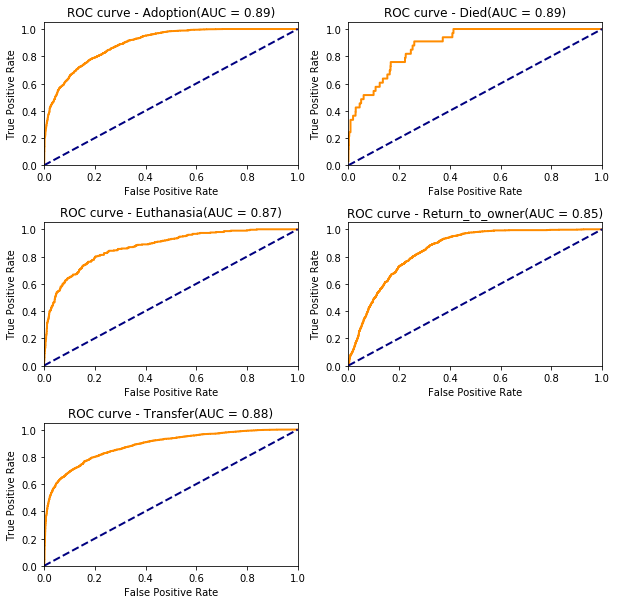

In [189]:
y_test_bin = label_binarize(y_test[:,0], GB.classes_)
plotROCCurves(GB.classes_, labelMapper.features[0][1].inverse_transform(GB.classes_), y_test_bin, proba)

Also generate a confusion matrix for the predictions.

In [190]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test[:,0], preds)#y_train[:,0]
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']


array([[1821,    0,    3,  214,  181],
       [   4,    3,    3,    1,   22],
       [  43,    3,   59,   68,  125],
       [ 372,    0,    4,  450,  135],
       [ 316,    1,   26,  152, 1340]])

Load the Kaggle test set and prepare predictions to submit to Kaggle

In [191]:
testdf = pd.read_csv("test.csv")

splitSex(testdf)
cleanupBreed(testdf)
testdf = processBreed(testdf, True) 
processAge(testdf)    
processDate(testdf)
processWeekend(testdf)
processName(testdf)
processColor(testdf)


prepared_testdf = testdf.copy()
print prepared_testdf.head()
prepared_testdf = prepared_testdf.drop(["ID", "Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_testdf.head()

prepared_fitted_testdf = mapper.fit_transform(prepared_testdf)

print prepared_fitted_testdf.columns
# Drop redundant columns to avoid the Dummy Variable Trap
prepared_fitted_testdf = prepared_fitted_testdf.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor" ], axis=1)
prepared_fitted_testdf.head()

(11456, 262)
0.421725288447
NumDims= 45
(11456, 45)
   ID      Name            DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer 2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne 2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus 2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo 2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter 2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color     Sex  Neutered     ...       \
0          Labrador Retriever Mix    Red/White  female         0     ...        
1  German Shepherd/Siberian Husky    Black/Tan  female         1     ...        
2          Domestic Shorthair Mix  Brown Tabby    male         1     ...        
3               Collie Smooth Mix     Tricolor    male         0     ...        
4            Miniature Poodle Mix        White    male        

,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_39,Breed_40,Breed_41,Breed_42,Breed_43,Breed_44,AgeDays,OutcomeDay,OutcomeMonth,OutcomeHour
0,1,1,0,0,0,0,0,1,0,0,...,0.00284081,-0.0141782,0.00417197,0.00124011,0.00361832,0.00263329,300,12,10,12
1,1,1,0,1,0,1,0,0,0,0,...,-0.00290592,-0.0071319,-0.00833613,-0.020529,-0.015255,-0.00476314,730,26,7,17
2,0,0,1,1,0,0,0,1,0,0,...,9.44868e-06,8.00508e-05,5.59745e-06,3.90603e-05,-0.000160389,4.18726e-05,365,13,1,12
3,1,0,1,0,0,0,0,1,0,0,...,-0.00702014,0.0288,0.0234145,0.0187252,0.0566832,0.00594066,120,28,12,18
4,1,0,1,1,0,1,0,0,0,0,...,0.00128108,0.00272011,-0.0198743,0.00547661,-0.00354888,-0.000299144,730,24,9,17


In [192]:
X_kaggle_test = prepared_fitted_testdf.values
print prepared_fitted_testdf.head()
print prepared_fitted_df.head()
preds = GB.predict(X_kaggle_test[:,final_support])
probs = GB.predict_proba(X_kaggle_test[:,final_support])
print GB.classes_
print labelMapper.features[0][1].inverse_transform(GB.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf

  AnimalType Sex_female Sex_male Neutered PureBreed AgeBracket_adult  \
0          1          1        0        0         0                0   
1          1          1        0        1         0                1   
2          0          0        1        1         0                0   
3          1          0        1        0         0                0   
4          1          0        1        1         0                1   

  AgeBracket_baby AgeBracket_juvenile DaySegment_HR_0 DaySegment_HR_1  \
0               0                   1               0               0   
1               0                   0               0               0   
2               0                   1               0               0   
3               0                   1               0               0   
4               0                   0               0               0   

      ...         Breed_39     Breed_40     Breed_41     Breed_42  \
0     ...       0.00284081   -0.0141782   0.00417197   0.00

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.024198,0.011833,0.160963,0.035549,0.767457
1,2,0.702306,0.004225,0.063029,0.069152,0.161289
2,3,0.733127,0.002191,0.007037,0.129500,0.128145
3,4,0.087972,0.031484,0.171908,0.065373,0.643264
4,5,0.656561,0.004601,0.069252,0.056944,0.212642
5,6,0.217301,0.010480,0.188663,0.121646,0.461910
6,7,0.080137,0.024450,0.688491,0.031426,0.175496
7,8,0.870979,0.009253,0.010747,0.020537,0.088484
8,9,0.853462,0.004276,0.010347,0.025525,0.106390
9,10,0.775374,0.004464,0.027960,0.047861,0.144341
